## This notebook shows how calibrating PS data using the selection mechanism works.
It also compares results to the old getps method.

In [1]:
import numpy as np
from astropy.io import fits
import dysh.util as util
from dysh.util import sq_weighted_avg
from dysh.fits.gbtfitsload import GBTFITSLoad
from copy import deepcopy
import os
import wget
#from dysh.coordinates import Observatory

In [2]:
# The folder with the SDFITS files.
# for testing on GBO replace data_dir with /home/dysh
data_dir = "/bigdisk/data/gbt/"
data_file = data_dir+ "examples/onoff-L/data/TGBT21A_501_11.raw.vegas"

In [3]:
sdf = GBTFITSLoad(data_file)
sdf.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,144,PSR_B0329+54,0.0,Track,1,1.617185,1.420406,5,2,3700,1,327.088873,17.777965
1,152,NGC2415,3784.0,OnOff,1,1.617185,1.420406,5,2,151,1,286.218008,41.62843
2,153,NGC2415,3784.0,OnOff,2,1.617185,1.420406,5,2,151,1,286.886521,41.118134
3,154,3C196,0.0,OnOff,1,1.617185,1.420406,5,2,16,1,302.408541,49.254842
4,155,3C196,0.0,OnOff,2,1.617185,1.420406,5,2,16,1,303.968672,49.159197
5,156,NGC2782,2543.139777,OnOff,1,1.617185,1.420406,5,2,76,1,286.315641,57.760857
6,157,NGC2782,2543.139777,OnOff,2,1.617185,1.420406,5,2,76,1,285.968174,58.709599
7,158,NGC2782,2543.139777,OnOff,1,1.617185,1.420406,5,2,76,1,287.067642,55.736551
8,159,NGC2782,2543.139777,OnOff,2,1.617185,1.420406,5,2,76,1,286.705791,56.681541
9,167,ScoX-1,0.0,OnOff,1,5.375,4.5,8,2,11,1,126.125201,16.227996


### First run the old version of getps.  

In [4]:
%%time
psscan = sdf._oldgetps([156, 158], ifnum=0, plnum=0)

AttributeError: 'GBTFITSLoad' object has no attribute '_oldgetps'

## Note this *incorrectly* puts all the scans into one PSScan

In [5]:
print(np.shape(psscan[0]._calibrated))

NameError: name 'psscan' is not defined

## Now run the version that uses the Selection object.
It takes longer than the old style.  We still need to profile the new code and see where it is spending time.

In [ ]:
%%time 
psscan2= sdf.getps(scan=[156,158],ifnum=0,plnum=0)

### It *correctly* separates the scan pairs into individual PSScans

In [ ]:
print(np.shape(psscan2[0]._calibrated),np.shape(psscan2[1]._calibrated))

### now get the same data using selection

In [ ]:
sdf.select(scan=[156,158],ifnum=0,plnum=0)
psscan3 = sdf.getps()

In [ ]:
ta2=psscan2.timeaverage()
ta3=psscan3.timeaverage()
np.all(ta2.data == ta3.data)

---

### Now compare the old getps for a single scan pair with new getps

In [ ]:
# first remove the selection made above
sdf.selection.remove(0)

In [ ]:
ps1 = sdf._oldgetps(scans=[156],ifnum=0,plnum=0)
ps2 = sdf.getps(scan=[156],ifnum=0,plnum=0)
ta1 = ps1.timeaverage()
ta2 = ps2.timeaverage()
np.all(ta1.data == ta2.data)

In [ ]:
ta1.plot()

In [ ]:
ta2.plot()

------

### Now do Total Power Scan

In [6]:
tpscan  = sdf.gettp(scan=156,cal=False,sig=True, ifnum=0,plnum=0, debug=True)

FINAL i [0] p [0] s [156] f [0]
TPROWS len= 76
CALROWS on len= 76
fitsindex= 0
TPSCAN pols=[0]
TPROWS len= 0
CALROWS on len= 0
fitsindex= 1


/home/mpound/src/dysh/src/dysh/spectra/core.py:352: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


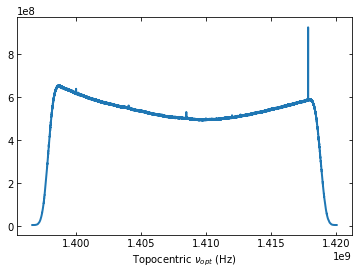

In [7]:
ta1=tpscan.timeaverage()
ta1.plot()

In [8]:
sdf.select(scan=156,ifnum=0,plnum=0)
tpscan2= sdf.gettp(cal=False,sig=True)
ta2 = tpscan2.timeaverage()
np.all(ta2.data == ta1.data)

TPSCAN pols=[0]


/home/mpound/src/dysh/src/dysh/spectra/core.py:352: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


True

------

## Now do sub beam nod scan

TRCO_230413_Ka.raw.vegas.A.fits already downloaded
{'SCAN': 43, 'FDNUM': 1, 'IFNUM': 0}


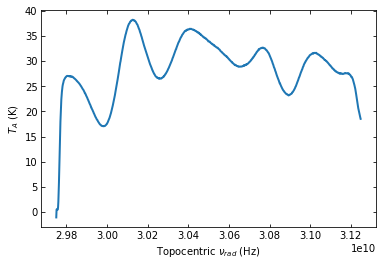

In [2]:
filename="TRCO_230413_Ka.raw.vegas.A.fits"
if not os.path.isfile(filename):
    url = f"http://www.gb.nrao.edu/dysh/example_data/subbeamnod-Ka/data/TRCO_230413_Ka.raw.vegas/{filename}"
    print(f"Downloading {filename}")
    wget.download(url,out=filename)
    print(f"\nRetrieved {filename}")
else:
    print(f"{filename} already downloaded")
sdfits = GBTFITSLoad(filename)
sdfits.summary()
sbnk = sdfits.subbeamnod(scan=43,fdnum=1,ifnum=0,weights='tsys', method='cycle')
ta = sbnk.timeaverage(weights='tsys')
ta.plot()

In [3]:
sdfits.select(ifnum=0,fdnum=1,scan=43)
ta2 = sdfits.subbeamnod(weights='tsys', method='cycle').timeaverage()

{}


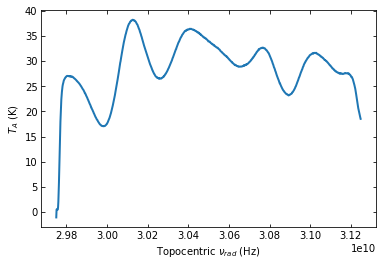

True

In [4]:
ta2.plot()
np.all(ta2.data == ta.data)